In [5]:
import os
import folium
import pandas as pd
import numpy as np

# Obtain data

In [6]:
import requests
import time
response = requests.get("http://opendata.paris.fr/api/records/1.0/download/?dataset=stations-velib-disponibilites-en-temps-reel&facet=banking&facet=bonus&facet=status&facet=contract_name&rows=-1")
txt = response.text
f = open('velib.csv', 'w+')
f.write(txt)

189415

In [7]:
velibs = pd.read_csv('velib.csv', sep=";")

In [8]:
velibs.head()

,number,name,address,position,banking,bonus,status,contract_name,bike_stands,available_bike_stands,available_bikes,last_update
0,5035,05035 - BUFFON AUSTERLITZ,1 RUE BUFFON - 75005 PARIS,"48.8431581782, 2.36374844464",True,False,CLOSED,Paris,24,0,0,2017-04-20T06:58:24+00:00
1,5104,05104 - BUFFON,47 RUE BUFFON - 75005 PARIS,"48.8419161798, 2.35891268132",True,False,CLOSED,Paris,55,0,0,2017-04-20T07:56:57+00:00
2,19116,19116 - JAURES VILLETTE,180 BOULEVARD DE LA VILLETTE - 75019 PARIS,"48.8814724985, 2.37026248226",True,False,CLOSED,Paris,30,0,0,2017-05-10T01:35:08+00:00
3,12019,12019 - GARE DE REUILLY,58 RUE DE LA GARE DE REUILLY - 75012 PARIS,"48.8425771005, 2.3972499906",True,False,OPEN,Paris,28,21,6,2017-05-28T09:14:22+00:00
4,33009,33009 - FELIX (AUBERVILLIERS),120 BOULEVARD FELIX FAURE - 93300 AUBERVILLIERS,"48.9078857573, 2.37883847406",True,False,OPEN,Paris,33,10,23,2017-05-28T10:50:01+00:00


In [9]:
velibs.shape

(1228, 12)

In [10]:
velibs = velibs[velibs.status == 'OPEN']

In [11]:
velibs['arron'] = velibs['address'].map(lambda x: int(x.split()[-2][3:]) if x.split()[-2][:2] == '75' else np.NaN)

In [12]:
velibs.shape

(1209, 13)

In [13]:
velibs.head()

,number,name,address,position,banking,bonus,status,contract_name,bike_stands,available_bike_stands,available_bikes,last_update,arron
3,12019,12019 - GARE DE REUILLY,58 RUE DE LA GARE DE REUILLY - 75012 PARIS,"48.8425771005, 2.3972499906",True,False,OPEN,Paris,28,21,6,2017-05-28T09:14:22+00:00,12.0
4,33009,33009 - FELIX (AUBERVILLIERS),120 BOULEVARD FELIX FAURE - 93300 AUBERVILLIERS,"48.9078857573, 2.37883847406",True,False,OPEN,Paris,33,10,23,2017-05-28T10:50:01+00:00,NaN
5,8020,08020 - METRO ROME,74 BOULEVARD DES BATIGNOLLES - 75008 PARIS,"48.8821489456, 2.31986005477",True,True,OPEN,Paris,44,44,0,2017-05-28T10:57:49+00:00,8.0
6,1022,01022 - RUE DE LA PAIX,37 RUE CASANOVA - 75001 PARIS,"48.8682170168, 2.3304935114",True,False,OPEN,Paris,37,34,3,2017-05-28T10:58:22+00:00,1.0
8,7012,07012 - CITE VANEAU,7 CITE VANEAU - 75007 PARIS,"48.8542683341, 2.31945401006",True,False,OPEN,Paris,36,18,18,2017-05-28T10:58:34+00:00,7.0


# Number of bike stands

In [14]:
bike_stands_arron = velibs.groupby('arron')['bike_stands'].sum()
print(bike_stands_arron)

arron
1.0      812
2.0      681
3.0      403
4.0      714
5.0     1108
6.0      990
7.0     1362
8.0     1770
9.0     1199
10.0    1497
11.0    2128
12.0    2603
13.0    2414
14.0    1842
15.0    3316
16.0    2198
17.0    1837
18.0    1827
19.0    1823
20.0    1808
Name: bike_stands, dtype: int64


In [15]:
# https://github.com/codeforamerica/click_that_hood/raw/master/public/data/paris.geojson
state_geo = r'paris.json'

m = folium.Map(location=[48.856614, 2.3522219], zoom_start=13, tiles='Stamen Toner')
m.choropleth(geo_path=state_geo, 
             data=bike_stands_arron,
             columns=['arron', 'bike_stands'],
             key_on='properties.cartodb_id',
             fill_color='YlGn', 
             fill_opacity=0.9, line_opacity=0.2,
             legend_name='Number of bike stands',
             highlight=1)
m

# Available bikes

In [16]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green").hex,10))
def red(brightness):
    brightness = int(round(9 * brightness)) # convert from 0.0-1.0 to 0-255
    return colors[brightness]

In [17]:
red(0).hex

'#f00'

In [18]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=13, tiles='Stamen Toner')

for k,v in velibs.iterrows():
    folium.CircleMarker(location=[v.position.split(",")[0], v.position.split(",")[1]], 
                        fill_color=red(v.available_bikes/float(v.bike_stands)).hex,
                        popup= str(v.available_bikes) + " / " + str(v.bike_stands),
                        radius=7).add_to(m)

In [19]:
m

# Utilisation 

In [20]:
import glob as glob

In [21]:
df = pd.DataFrame(columns=np.append("Date",velibs.number.values))
for i, name in enumerate(glob.glob('velib/*')):
    #print(name.split("velib")[2])
    velibs_temp = pd.read_csv(name, sep=";")
    positions = {}
    #print(name.split("velib")[2])
    positions['Date'] = name.split("velib")[2].split(".")[0]
    for k,v in velibs_temp.iterrows():
        positions[str(v.number)] = v.available_bikes
    
    df.loc[i] = pd.Series(positions)

In [22]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d-%H-%M', errors='coerce')

In [23]:
df = df.sort('Date').reset_index(drop=True)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


In [24]:
df.head()

,Date,12019,33009,8020,1022,7012,19019,20027,6006,9019,...,4013,20048,18016,16036,10110,7020,22001,12039,10151,20503
0,2017-05-07 09:32:00,8.0,32.0,6.0,0.0,4.0,2.0,0.0,4.0,0.0,...,11.0,3.0,0.0,46.0,3.0,54.0,20.0,37.0,8.0,15.0
1,2017-05-07 10:32:00,3.0,31.0,5.0,1.0,4.0,3.0,0.0,5.0,0.0,...,16.0,1.0,0.0,46.0,3.0,54.0,17.0,34.0,11.0,11.0
2,2017-05-07 11:32:00,2.0,32.0,9.0,4.0,5.0,2.0,0.0,5.0,0.0,...,14.0,1.0,0.0,49.0,3.0,51.0,18.0,32.0,12.0,12.0
3,2017-05-07 12:33:00,6.0,33.0,3.0,1.0,9.0,3.0,0.0,6.0,0.0,...,17.0,1.0,1.0,49.0,4.0,57.0,20.0,35.0,8.0,4.0
4,2017-05-07 13:33:00,7.0,33.0,2.0,2.0,16.0,2.0,0.0,2.0,1.0,...,10.0,5.0,0.0,52.0,2.0,49.0,19.0,35.0,17.0,10.0


In [25]:
df.ix[:, df.columns != 'Date'].sum(axis=1).mean()

15522.667464114833

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

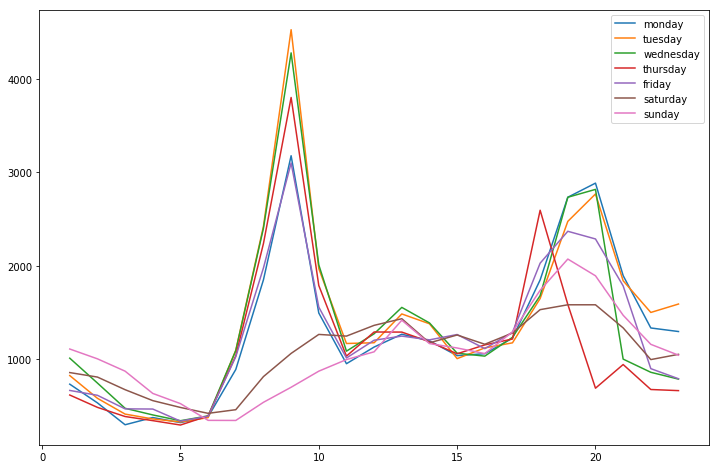

In [29]:
plt.figure(figsize=(12,8))
weekday = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
for i in range(15,22):
    subdf = df[df['Date'].dt.day == i]
    plt.plot(subdf.Date.dt.hour, subdf.ix[:, df.columns != 'Date'].diff().clip(0).sum(axis=1),label=weekday[i-15])

plt.legend(loc='best')
plt.show()  

In [34]:
import pygal
from IPython.display import SVG, HTML

In [35]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [38]:
line_chart = pygal.Line(x_title='Time [hour]',y_title='Number of used bikes')
line_chart.title = 'Number of used bikes'
line_chart.x_labels = range(0, 24)
weekday = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
for i in range(15,22):
    subdf = df[df['Date'].dt.day == i]
    tmp_df = subdf.ix[:, df.columns != 'Date'].diff().clip(0).sum(axis=1).values[1:]
    line_chart.add(weekday[i-15], tmp_df)

HTML(html_pygal.format(pygal_render=line_chart.render()))